## Importing Libraries

In [903]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, jaccard_score
import plotly.express as px
import numpy as np
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot as plt
import seaborn as sns


## Loading the Data

In [904]:
df = pd.read_csv("Breast_Cancer.csv", header=0, delimiter=',')
df.head()

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive


## Dataset Inspection

In [905]:
numerical_cols = ['Age','Tumor Size','Regional Node Examined','Reginol Node Positive','Survival Months']
categorical_cols = ['Race','Marital Status','T Stage ','N Stage','6th Stage','differentiate','Grade','A Stage','Estrogen Status','Progesterone Status']

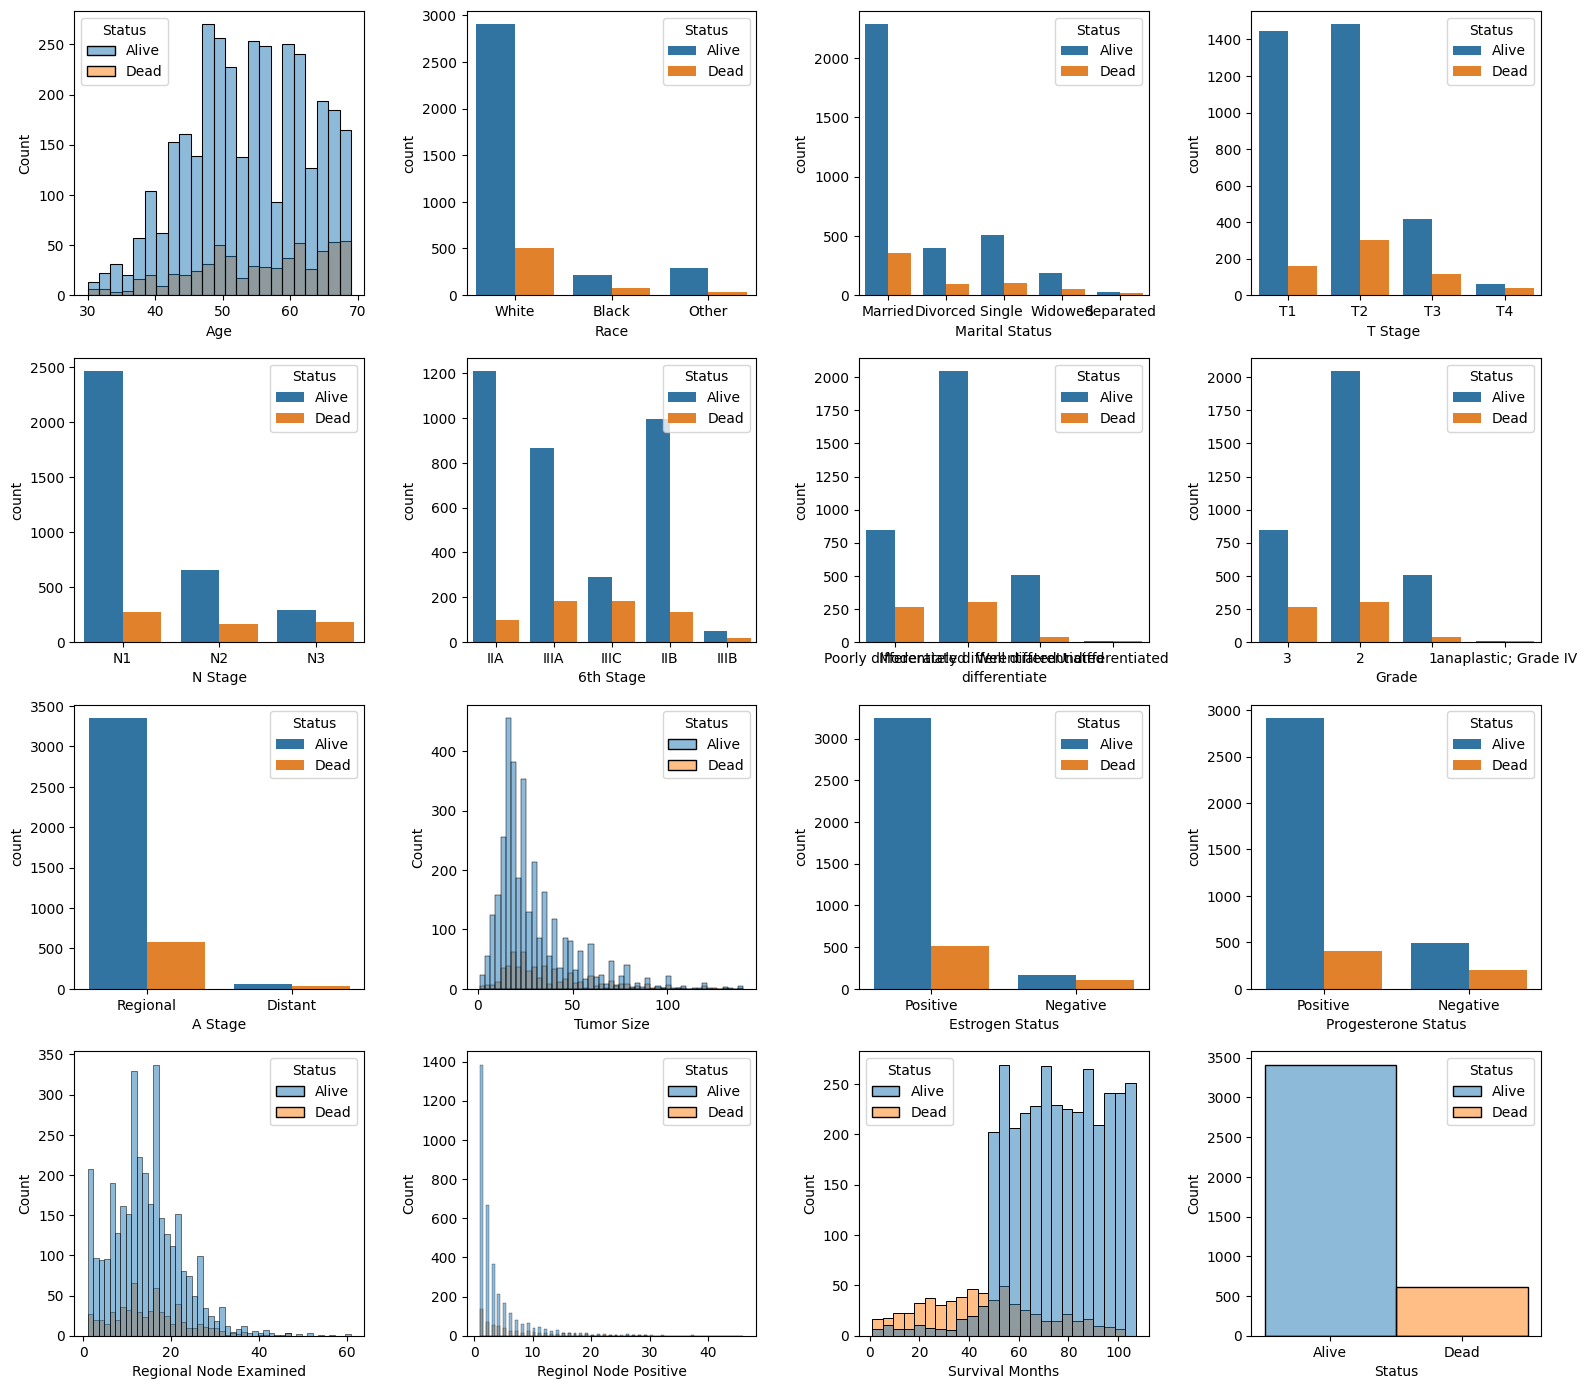

In [906]:
fig, axes = plt.subplots(4,4,figsize=(16,14))

for i, c in enumerate(df.columns):
    ax = axes.reshape(-1)[i]
    if c in categorical_cols:
        a = sns.countplot(x=c,data=df, ax=ax, hue='Status');
    else: 
        sns.histplot(x=c,data=df, hue='Status',ax=ax)
plt.tight_layout()

## Train Test Split

In [907]:
X = df.loc[:,df.columns != 'Status']
y = df['Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)


## Preprocessing

In [908]:
def preprocessing(X, y, scaler=None):
    # We scale all the columns
    if scaler is None: 
        # We only want the scaler to fit the train data
        scaler = MinMaxScaler()
        X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    else: 
        X[numerical_cols] = scaler.transform(X[numerical_cols])
    # One Hot Encoding
    X = pd.get_dummies(X, columns = categorical_cols)
    # Encode output
    status_map = {'Dead': 1, 'Alive': 0}
    y = y.map(status_map)
    y = y.rename('Dead')
    return X, y, scaler

X_train, y_train, scaler = preprocessing(X_train,y_train)
X_val, y_val, _ = preprocessing(X_val, y_val, scaler)
X_test, y_test, _ = preprocessing(X_test,y_test,scaler)

## Outlier Detection

In [909]:
# Outlier detection
joined = X_train.join(y_train)
local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
result = local_outlier_factor.fit_predict(joined[numerical_cols])
no_outliers = result == 1
joined = joined[no_outliers]
y_train = joined.pop('Dead')
X_train = joined

## Data Balancing

In [910]:
print('Original dataset shape:', Counter(y_train))

Original dataset shape: Counter({0: 2642, 1: 453})


In [911]:
from imblearn.combine import SMOTEENN

# Apply SMOTEENN for combined oversampling and undersampling
smote_enn = SMOTEENN(sampling_strategy='minority')
X_train, y_train = smote_enn.fit_resample(X_train, y_train)

print('Resampled dataset shape:', Counter(y_train))


Resampled dataset shape: Counter({1: 2158, 0: 1734})


## Support Functions

In [912]:
results_df = pd.DataFrame(index=[], columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

In [913]:
def compute_metrics(y_real,y_pred):
    accuracy = accuracy_score(y_real, y_pred)
    f1 =f1_score(y_real,y_pred, pos_label=1)
    precision = precision_score(y_real, y_pred, pos_label=1)
    recall =recall_score(y_real,y_pred, pos_label=1)
    jaccard = jaccard_score(y_real, y_pred, pos_label=1)
    return [accuracy, f1, precision, recall, jaccard]

## LDA

In [914]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred_lda = lda_model.predict(X_val)
results_df.loc['LDA',:] = compute_metrics(y_val, y_pred_lda)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.807163,0.539474,0.427083,0.732143,0.369369


## KNN

In [915]:
from sklearn.neighbors import KNeighborsClassifier


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'k'))
results_knn = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

k_values = range(1,50,2)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski')
    knn = knn.fit(X_train,y_train)
    y_pred = knn.predict(X_val)
    results_knn.loc[('KNN',k), :] = compute_metrics(y_val, y_pred)

sorted_results_knn = results_knn.sort_values(by='Recall', ascending=False)
print(sorted_results_knn)

          Accuracy        F1 Precision    Recall   Jaccard
model k                                                   
KNN   49  0.606061  0.352941  0.236364  0.696429  0.214286
      47  0.603306  0.351351   0.23494  0.696429  0.213115
      27  0.650138  0.374384  0.258503  0.678571  0.230303
      45  0.600551  0.343891  0.230303  0.678571   0.20765
      9   0.652893  0.376238  0.260274  0.678571  0.231707
      11  0.663912  0.383838  0.267606  0.678571    0.2375
      43  0.608815  0.348624  0.234568  0.678571  0.211111
      17  0.663912  0.383838  0.267606  0.678571    0.2375
      19  0.655647  0.378109  0.262069  0.678571  0.233129
      33  0.639118   0.36715  0.251656  0.678571  0.224852
      29  0.650138  0.374384  0.258503  0.678571  0.230303
      41   0.61157  0.344186  0.232704  0.660714  0.207865
      39   0.61157  0.344186  0.232704  0.660714  0.207865
      25  0.644628  0.364532  0.251701  0.660714  0.222892
      21  0.641873  0.362745      0.25  0.660714  0.2215

In [916]:

# Retrieve the k value of the first row
first_row = sorted_results_knn.iloc[0]
k_value = first_row.name[1]

print("k value of the first row:", k_value)

knn = KNeighborsClassifier(n_neighbors=k_value)
knn = knn.fit(X_train,y_train)
y_pred_knn = knn.predict(X_val)
results_df.loc['KNN-'+str(k_value), :] = compute_metrics(y_val, y_pred_knn)
results_df

k value of the first row: 49


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.807163,0.539474,0.427083,0.732143,0.369369
KNN-49,0.606061,0.352941,0.236364,0.696429,0.214286


## Logistic Regression

In [917]:
from sklearn.linear_model import LogisticRegression


index= pd.MultiIndex.from_arrays([[], []], names=('model', 'C'))
results_logreg = pd.DataFrame(index=index, columns= ['Accuracy', 'F1', 'Precision', 'Recall', 'Jaccard'])

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]

for l in lambdas:
    C = 1/l
    logreg = LogisticRegression(C=C, max_iter=1000)
    logreg = logreg.fit(X_train,y_train)
    y_pred = logreg.predict(X_val)
    results_logreg.loc[('LogReg', C), :] = compute_metrics(y_val, y_pred)

sorted_results_logreg = results_logreg.sort_values(by='Recall', ascending=False)
print(sorted_results_logreg)

                 Accuracy        F1 Precision    Recall   Jaccard
model  C                                                         
LogReg 1.0       0.801653  0.532468  0.418367  0.732143  0.362832
       10.0      0.804408  0.529801  0.421053  0.714286   0.36036
       0.1       0.754821  0.467066  0.351351  0.696429  0.304688
       100000.0  0.798898  0.503401  0.406593  0.660714  0.336364
       10000.0   0.798898  0.503401  0.406593  0.660714  0.336364
       1000.0    0.798898  0.503401  0.406593  0.660714  0.336364
       100.0     0.798898  0.503401  0.406593  0.660714  0.336364


In [918]:
# Retrieve the k value of the first row
first_row = sorted_results_logreg.iloc[0]
c_value = first_row.name[1]

print("c value of the first row:", c_value)

logreg = LogisticRegression(C=c_value, max_iter=1000).fit(X_train,y_train)
y_pred_logreg = logreg.predict(X_val)
results_df.loc['LogReg-'+str(c_value), :] = compute_metrics(y_val, y_pred_logreg)

results_df.sort_values(by='Recall', ascending=False)

c value of the first row: 1.0


,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.807163,0.539474,0.427083,0.732143,0.369369
LogReg-1.0,0.801653,0.532468,0.418367,0.732143,0.362832
KNN-49,0.606061,0.352941,0.236364,0.696429,0.214286


## Random Forest

In [919]:
rfmodel=RandomForestClassifier(n_estimators=600)
rfmodel.fit(X_train, y_train)
y_pred_rf = rfmodel.predict(X_val)
results_df.loc['Random Forest',:] = compute_metrics(y_val, y_pred_rf)
results_df

,Accuracy,F1,Precision,Recall,Jaccard
LDA,0.807163,0.539474,0.427083,0.732143,0.369369
KNN-49,0.606061,0.352941,0.236364,0.696429,0.214286
LogReg-1.0,0.801653,0.532468,0.418367,0.732143,0.362832
Random Forest,0.823691,0.536232,0.45122,0.660714,0.366337


## Generalization Performance

In [920]:
y_pred=logreg.predict(X_test)

In [921]:
print('accuracy_score: ',accuracy_score(y_test,y_pred))
print('recall_score: ',recall_score(y_test,y_pred))
print('jaccard_score: ',jaccard_score(y_test,y_pred))
print('f1_score: ',f1_score(y_test,y_pred))
print('precision_score: ',precision_score(y_test,y_pred))

fig = px.imshow(np.around(confusion_matrix(y_test, y_pred, normalize='true'),2), 
                template='ggplot2',
                text_auto=True, 
                aspect="True", 
                labels=dict(x="Predicted Label", y="Correct Label", color='Value'))
fig.update_xaxes(side="bottom")
fig.show()

accuracy_score:  0.8213399503722084
recall_score:  0.8064516129032258
jaccard_score:  0.4098360655737705
f1_score:  0.5813953488372092
precision_score:  0.45454545454545453
